### Importovanie potrebných knižníc a nástrojov

In [ ]:
import matplotlib.pyplot as plt
import pathlib
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

### Pripojenie Google disku pre načítanie datasetov

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TRAIN_DATA_DIR_GDRIVE = "/content/drive/MyDrive/Colab Notebooks/train_2vs2"
VALIDATION_DATA_DIR_GDRIVE = "/content/drive/MyDrive/Colab Notebooks/validation_2vs2"
TEST_DATA_DIR_GDRIVE = "/content/drive/MyDrive/Colab Notebooks/test_2vs2"

In [ ]:
!cp -r "$TRAIN_DATA_DIR_GDRIVE" .
!cp -r "$VALIDATION_DATA_DIR_GDRIVE" .
!cp -r "$TEST_DATA_DIR_GDRIVE" .

In [ ]:
TRAIN_DATA_DIR = './train_2vs2'
VALIDATION_DATA_DIR = './validation_2vs2'
TEST_DATA_DIR = './test_2vs2'

TRAIN_DATASET_PATH = pathlib.Path(TRAIN_DATA_DIR)
VALIDATION_DATASET_PATH = pathlib.Path(VALIDATION_DATA_DIR)
TEST_DATASET_PATH = pathlib.Path(TEST_DATA_DIR)

In [ ]:
BATCH_SIZE = 32
IMG_SIZE=(224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DATA_DIR,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  VALIDATION_DATA_DIR,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  VALIDATION_DATA_DIR,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 3365 files belonging to 4 classes.
Found 84 files belonging to 4 classes.
Found 84 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['E_Boletus_reticulatus', 'E_Cantharellus_cibarius', 'P_Amanita_muscaria', 'P_Gyromitra_esculenta']


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
vgg = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False, classifier_activation="softmax") 

In [ ]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)

In [ ]:
prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(0.0003),
  metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[early_stop],
  batch_size=BATCH_SIZE,
  shuffle=True)

Epoch 1/10
106/106 [==============================] - 43s 381ms/step - loss: 1.1732 - accuracy: 0.9067 - val_loss: 0.2441 - val_accuracy: 0.9881
Epoch 2/10
106/106 [==============================] - 42s 377ms/step - loss: 0.0475 - accuracy: 0.9938 - val_loss: 0.4377 - val_accuracy: 0.9524
Epoch 3/10
106/106 [==============================] - 42s 375ms/step - loss: 0.0363 - accuracy: 0.9949 - val_loss: 0.4314 - val_accuracy: 0.9762
Epoch 4/10
106/106 [==============================] - 42s 376ms/step - loss: 0.0125 - accuracy: 0.9979 - val_loss: 0.2838 - val_accuracy: 0.9762
Epoch 5/10
106/106 [==============================] - 42s 375ms/step - loss: 0.0066 - accuracy: 0.9988 - val_loss: 0.2738 - val_accuracy: 0.9762
Epoch 6/10
106/106 [==============================] - 42s 376ms/step - loss: 0.0223 - accuracy: 0.9973 - val_loss: 0.2316 - val_accuracy: 0.9762
Epoch 7/10
106/106 [==============================] - 42s 378ms/step - loss: 0.0329 - accuracy: 0.9947 - val_loss: 0.1294 - val_ac

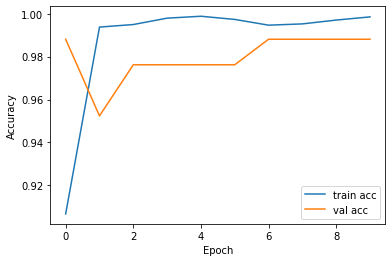

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

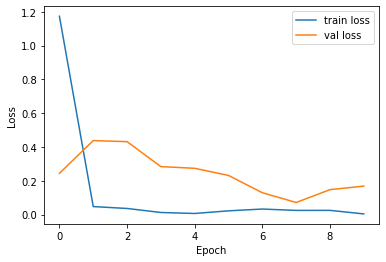

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### **Testovanie modelu**

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds,batch_size=BATCH_SIZE)
print("Testovacia loss {0:.2f}, Testovacia accuracy {1:.2f}%".format(test_loss, test_accuracy * 100))

3/3 [==============================] - 2s 329ms/step - loss: 0.1686 - accuracy: 0.9881
Testovacia loss 0.17, Testovacia accuracy 98.81%


In [ ]:
test_datagen = ImageDataGenerator()

test_dataset = test_datagen.flow_from_directory(
      TEST_DATASET_PATH, 
      target_size=IMG_SIZE, 
      class_mode='categorical', 
      batch_size=BATCH_SIZE, 
      shuffle=False
)

Found 84 images belonging to 4 classes.


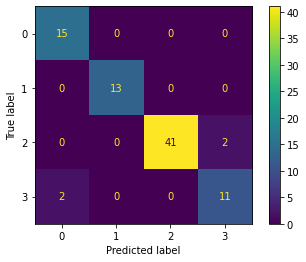

In [ ]:
Y_true_classes = test_dataset.classes
Y_predict = model.predict(test_dataset)

Y_pred_classes = np.argmax(Y_predict, axis=1)

CONFUSION_MATRIX = confusion_matrix(Y_true_classes, Y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=CONFUSION_MATRIX)

disp = disp.plot()

In [ ]:
print(classification_report(Y_true_classes, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        15
           1       1.00      1.00      1.00        13
           2       1.00      0.95      0.98        43
           3       0.85      0.85      0.85        13

    accuracy                           0.95        84
   macro avg       0.93      0.95      0.94        84
weighted avg       0.96      0.95      0.95        84

